> **NOMBRE:** ENGER ISAAC CANUL POOT


## **INSTALACIONES Y LIBRERIAS:**


**NOTA:** _Para la realización de estas prácticas se creo un ambiente en Anaconda con la versión de Python 3.5.6._


In [1]:
# !pip install networkx==1.11


In [2]:
import networkx as nx  # Con la versión 1.11
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.classes.function import common_neighbors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics


## **INTRODUCCIÓN:**


Los gráficos o redes son estructuras de datos que permiten representar las relaciones entre varias entidades. Se utilizan en muchos escenarios de la vida real, como en las redes sociales, la gestión de proyectos, la ingeniería, la biología, entre otros. Los gráficos constan de dos entidades principales: los nodos o vértices y los bordes. Los nodos representan las entidades del sistema y los bordes representan las relaciones entre ellas. Por ejemplo, en una red social, los nodos podrían representar usuarios y los bordes podrían representar la amistad entre ellos.

El análisis de gráficos puede ayudar a responder preguntas como:

¿Cuáles son los nodos más importantes en la red?
¿Existen comunidades o grupos de nodos que están muy conectados entre sí pero tienen pocas conexiones con otros grupos?
¿Existen patrones en la forma en que las entidades están conectadas en la red?

Los gráficos o redes son una estructura de datos utilizada para representar las relaciones entre entidades en diferentes escenarios de la vida real. El análisis de su estructura requiere un conjunto de algoritmos especializados y la comprensión de varias propiedades del grafo.


# **PRIMERA PARTE:**


En la primera parte de esta tarea trabajarás con la red que se forma a partir de las comunicaciones por correo electrónico en una compañía. Cada nodo corresponde a una persona y cada enlace indica que por lo menos se ha enviado un correo entre las personas.

La red también contiene los atributos `Department` y `ManagementSalary`. El atributo `Department` registra el departamento al cual pertenece cada persona y `ManagementSalary` indica si recibe un salario asociado con una posición directiva.


In [3]:
G = nx.read_gpickle('email_prediction.txt')
len(G.nodes())


1005

## **Instrucciones [primera parte]**

El objetivo de esta primera práctica es que construyas un modelo que prediga el valor de la variable `ManagementSalary`.

1. Ignora los casos en los que no se tiene registrada la etiqueta.
2. Separa el conjunto de datos en subconjuntos de entrenamiento y prueba.
3. Ajusta un modelo a los datos usando alguna técnica de aprendizaje adecuada. Puedes utilizar como predictores métricas que caractericen a los nodos (de centralidad, distancia, conexión, ...).
4. Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


## **LECTURA Y VISUALIZACIÓN DE LOS DATOS:**


Como podemos denotar por cada nodo hay un diccionario, en el que se destacan tres valores:

- **0:** No recibe un salario asociado con una posición directiva.
- **1:** Sí recibe un salario asociado con una posición directiva
- **nan:** Sin datos.


In [4]:
G.nodes(data=True)[0:10]


[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (7, {'Department': 14, 'ManagementSalary': 0.0}),
 (8, {'Department': 14, 'ManagementSalary': nan}),
 (9, {'Department': 14, 'ManagementSalary': 0.0})]

Podemos visualizar los nodos:


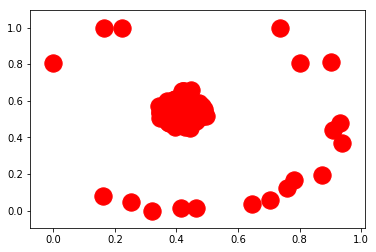

In [5]:
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G))


## **CONVERSIÓN A DATAFRAME:**


Para evaluar con mayor entendimiento la información podemos explorarlo a partir de un DataFrame, por lo que optaremos por transformar el Grafo. El objetivo de esta práctica es un modelo para predecir la variable **Management Salary**.


In [6]:
dat_node = {
    'Node': [],
    'Department': [],
    'Management Salary': []
}


Creación de las columnas del DataFrame.


In [7]:
for columns, data in G.nodes(data=True):
    dat_node['Node'].append(columns)
    dat_node['Department'].append(data['Department'])
    if not pd.isna(data['ManagementSalary']):
        dat_node['Management Salary'].append(int(data['ManagementSalary']))
    else:
        dat_node['Management Salary'].append(-1)  # convertimos nan a -1
df = pd.DataFrame(dat_node)
df.head()


,Department,Management Salary,Node
0,1,0,0
1,1,-1,1
2,21,-1,2
3,21,1,3
4,21,1,4


Asi mismo para crear el modelo, necesitamos variables predictoras y métricas de centralidad que son las medidas utilizadas para cuantificar la importancia o centralidad de los nodos en una red. Estas métricas proporcionan información sobre la posición de los nodos en la red y su capacidad para influir en la información o el flujo de recursos.

Las metricas que se usaran para este modelo son:

- **Grado:** El número de otros nodos que están conectados a un nodo.
- **Cercania:** Puntúa cada nodo en función de su "_cercanía_ a todos los demás nodos de la red.
- **Intermediación:** Muestra la cantidad de caminos más cortos que pasan por un nodo.
- **Grado de centralidad:** Número de enlaces o conexiones que posee un vértice con el resto de los nodos pertenecientes a un grafo.
- **Coeficiente de clusterización:** Cuantifica qué tanto está de agrupado (o interconectado) con sus vecinos.


In [8]:
# metricas de centralidad
df['Grado'] = nx.degree(G).values()
df['Cercania'] = nx.closeness_centrality(G).values()
df['Intermediacion'] = nx.betweenness_centrality(G).values()
# metricas de distancia
df['G_centralidad'] = nx.degree_centrality(G).values()
# metrica de conexion
df['Clusterizacion'] = nx.clustering(G).values()

df.head()


,Department,Management Salary,Node,Grado,Cercania,Intermediacion,G_centralidad,Clusterizacion
0,1,0,0,44,0.421991,0.001124,0.043825,0.276423
1,1,-1,1,52,0.422360,0.001195,0.051793,0.265306
2,21,-1,2,95,0.461490,0.006570,0.094622,0.297803
3,21,1,3,71,0.441663,0.001654,0.070717,0.384910
4,21,1,4,96,0.462152,0.005547,0.095618,0.318691


In [9]:
len(df)


1005

## **1. ELIMINAMOS LOS QUE CONTENGAN UN VALOR NAN:**


Como primer paso eliminaremos las filas con las etiquetas sin registro (nan) que anteriormente se convirtieron en **"-1"**.


In [10]:
id_remove = []
for i, data in df.iterrows():
    if data['Management Salary'] == -1:
        id_remove.append(i)

df.drop(index=id_remove, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()


,Department,Management Salary,Node,Grado,Cercania,Intermediacion,G_centralidad,Clusterizacion
0,1,0,0,44,0.421991,0.001124,0.043825,0.276423
1,21,1,3,71,0.441663,0.001654,0.070717,0.384910
2,21,1,4,96,0.462152,0.005547,0.095618,0.318691
3,25,1,6,115,0.475805,0.012387,0.114542,0.155183
4,14,0,7,72,0.420156,0.002818,0.071713,0.287785


Podemos denotar que pasamos de tener **1,005** datos a **753**.


In [11]:
len(df)


753

## **2. SUBCONJUNTO DE PRUEBA Y ENTRENAMIENTO:**


Dividiremos el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas, separando los datos en **80% en train** y el **20% en test**.


In [12]:
col_X = list(df.columns)
col_X


['Department',
 'Management Salary',
 'Node',
 'Grado',
 'Cercania',
 'Intermediacion',
 'G_centralidad',
 'Clusterizacion']

In [13]:
col_y = 'Management Salary'
col_y


'Management Salary'

In [14]:
col_X.remove(col_y)  # Removemos la columna Management Salary de las demás
X = df[col_X]
y = df[col_y]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


## **3. CREACIÓN Y AJUSTE DEL MODELO DE APRENDIZAJE:**


Este es un problema binario, ya que los datos que se manejan son **1 y 0**, por lo que podemos aplicar el modelo de **Regresión Logística**.


In [16]:
mod_lr = LogisticRegression()
mod_lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = mod_lr.predict(X_test)
y_pred


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [18]:
print('Accuracy:', mod_lr.score(X_test, y_test)*100)


Accuracy: 86.75496688741721


## **4. EVALUACIÓN DEL MODELO:**


Para evaluar el modelo a los datos de prueba se usará el **área bajo la curva ROC**, ROC es un acrónimo que viene del inglés Receiver Operating Characteristic (Característica Operativa del Receptor). Es una gráfica que enfrenta el ratio de falsos positivos (eje x) con el ratio de falsos negativos (eje y). Estos ratios los va obteniendo en función de una serie de umbrales definidos entre 0 y 1. En palabras comunes y referenciando al ejemplo anterior, enfrenta la **falsa alarma** vs la tasa de éxito.
La curva ROC es útil por dos principales motivos:

- Permite comparar diferentes modelos para identificar cual otorga mejor rendimiento como clasificador.
- El área debajo de la curva (AUC) puede ser utilizado como resumen de la calidad del modelo.


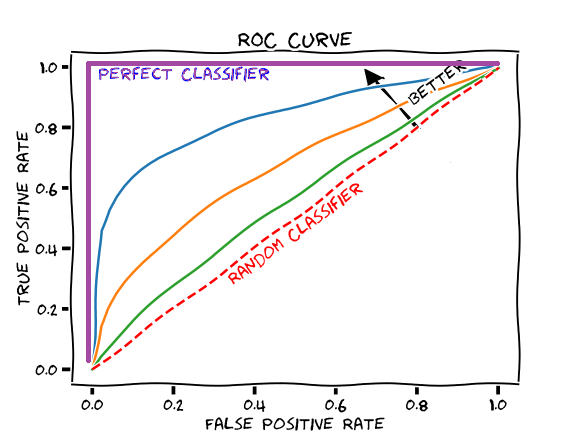


In [19]:
y_pred_prob = mod_lr.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)


In [20]:
print("AUC:", auc*100)


AUC: 86.54855643044618


La curva de característica operativa del receptor (ROC) es una gráfica de la tasa de positivos verdaderos contra la tasa de falsos positivos. Muestra la compensación entre sensibilidad y especificidad, la gráfica de la curva quedaría de la siguiente forma. El valor AUC se utiliza como resumen del rendimiento del modelo. Cuanto más esté hacia la izquierda la curva, más área habrá contenida bajo ella y por ende, mejor será el clasificador. El clasificador sin entrenar tendría una AUC de **50%** mientras que el clasificador perfecto tendría un AUC de 1, pero en nuestro caso supera el **82%**, que es lo minimo que se espera.


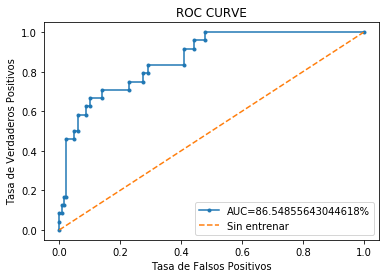

In [21]:
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, marker='.', label="AUC="+str(auc*100)+"%")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC CURVE')
plt.legend()
plt.show()


Cumplimos con la evaluación designada del punto cuatro, superando el **AUC del 82%** de lo antes evaluado. Por lo que nuestro modelo es capaz de predecir con una buena precisión si una persona en la red de correo electrónico recibe un salario de posición directiva o no. Esto podría tener implicaciones importantes como por ejemplo, en la gestión de recursos humanos de la compañía, ya que permitiría identificar de manera más eficiente a aquellos empleados que podrían ser considerados para posiciones de liderazgo.


# SEGUNDA PARTE:

En la última parte de esta práctica vas a predecir las futuras conexiones enyte los empleados de la red. La información de la formación de tales conexiones se encuentra en el archivo `future_connections`, cuyo índice es una dupla de nodos que no están conectados actualmente. La columna `Future Connection` indica si en el futuro se establecerá una arista entre ambos nodos (el valor de 1.0 indica una futura conexión).


In [22]:
df_p2 = pd.read_csv('Future_Connections.csv',
                    index_col=0, converters={0: eval})
df_p2.head(10)


,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


## Instrucciones [segunda parte]

Utiliza la reg `G` (de la primera parte) y `future_connections` para que construyas un modelo que identifique cuáles parejas de nodos en `future_connections` estarán conectados en el futuro.

Para lograrlo, deberás crear una matriz con métricas que caractericen a las aristas de `future_connections` utilizando networkx.

1. Elimina los casos en que la variable de respuesta no se encuentre registrada.
2. Evalúa las características de las parejas de nodos del archivo `future_connections`.
3. Separa los datos en subconjuntos de entrenamiento y prueba.
4. Ajusta un modelo adecuado para predecir la formación de enlaces.
5. Evalúa la calidad del modelo sobre el conjunto de prueba usando el área bajo la curva (tu modelo debe tener por lo menos un AUC de $0.82$ evaluada sobre el conjunto de prueba).


## DEFINICIÓN DE MÉTRICAS:


In [24]:
def get_values(pairs):
    return [i[2] for i in pairs]


Las métricas que se pueden calcular en una red y que se han utilizado para caracterizar las aristas de la red `future_connections` son:

- **Vecinos comunes:** Es el número de vecinos comunes que tienen dos nodos. Si dos nodos tienen muchos vecinos comunes, es más probable que estén conectados en la red.


In [25]:
def common_neighbors(g):
    comm_neigh = [(e[0], e[1], len(list(nx.common_neighbors(g, e[0], e[1]))))
                  for e in nx.non_edges(g)]
    return get_values(comm_neigh)


- **Coeficiente de Jaccard:** Mide la similitud entre dos conjuntos. En el contexto de una red, se utiliza para medir la similitud entre los vecinos de dos nodos. El coeficiente de Jaccard es mayor si dos nodos tienen vecinos similares y, por lo tanto, es más probable que estén conectados.


In [26]:
def jaccard_coefficient(g):
    jacc = list(nx.jaccard_coefficient(g))
    return get_values(jacc)


- **Distribución de recursos:** Mide la cantidad de recursos (por ejemplo, dinero, información) que fluye a través de una arista en la red. Esta métrica se utiliza para predecir la probabilidad de que una arista se forme en la red.


In [27]:
def resource_allocation(g):
    res = list(nx.resource_allocation_index(g))
    return get_values(res)


- **Índice Adamic-Adar:** Se basa en la idea de que los vecinos con pocos vecinos comunes son más importantes que los vecinos con muchos vecinos comunes. Por lo tanto, esta métrica da más peso a los vecinos comunes que son raros en la red.


In [28]:
def adamic_adar(g):
    adamic_adar = list(nx.adamic_adar_index(g))
    return get_values(adamic_adar)


- **Enlace preferencial:** Se basa en la idea de que los nodos con muchos vecinos tienen más probabilidades de ser conectados con nuevos nodos. Esta métrica se utiliza para predecir la probabilidad de que una arista se forme en la red.


In [29]:
def preferential_attachment(g):
    pref = list(nx.preferential_attachment(g))
    return get_values(pref)


## **EVALUACIÓN DE LAS CARACTERÍSTICAS:**


In [30]:
df_p2.sort_index(inplace=True)
df_p2['common_neighbors'] = common_neighbors(G)
df_p2['jacc_coef'] = jaccard_coefficient(G)
df_p2['res_alloc'] = resource_allocation(G)
df_p2['adamic_adar'] = adamic_adar(G)
df_p2['pref_attach'] = preferential_attachment(G)
df_p2.head(10)


,Future Connection,common_neighbors,jacc_coef,res_alloc,adamic_adar,pref_attach
"(0, 2)",0.0,6,0.045802,0.055340,1.257626,4180
"(0, 3)",0.0,3,0.027273,0.021388,0.605728,3124
"(0, 4)",0.0,3,0.022222,0.021388,0.605728,4224
"(0, 7)",0.0,4,0.036364,0.061668,0.938816,3168
"(0, 8)",0.0,1,0.012821,0.011628,0.224500,1628
"(0, 9)",NaN,2,0.025000,0.041931,0.510499,1760
"(0, 10)",0.0,1,0.011236,0.005882,0.194712,2068
"(0, 11)",0.0,4,0.035088,0.053661,0.899701,3344
"(0, 12)",0.0,4,0.041667,0.065762,0.953236,2552
"(0, 13)",0.0,7,0.032558,0.199248,1.943251,7920


Total de datos antes del filtrado del DataFrame.


In [31]:
len(df_p2)


488446

## **1. ELIMINAMOS LOS QUE CONTENGAN UN VALOR NAN:**


Eliminación de los registros cuya variable de respuesta sea **nan**.


In [32]:
nan = df_p2['Future Connection'].isnull()
# Filtramos las filas que no tienen valores faltantes
df_p2 = df_p2.loc[~nan]
df_p2.head(10)


,Future Connection,common_neighbors,jacc_coef,res_alloc,adamic_adar,pref_attach
"(0, 2)",0.0,6,0.045802,0.055340,1.257626,4180
"(0, 3)",0.0,3,0.027273,0.021388,0.605728,3124
"(0, 4)",0.0,3,0.022222,0.021388,0.605728,4224
"(0, 7)",0.0,4,0.036364,0.061668,0.938816,3168
"(0, 8)",0.0,1,0.012821,0.011628,0.224500,1628
"(0, 10)",0.0,1,0.011236,0.005882,0.194712,2068
"(0, 11)",0.0,4,0.035088,0.053661,0.899701,3344
"(0, 12)",0.0,4,0.041667,0.065762,0.953236,2552
"(0, 13)",0.0,7,0.032558,0.199248,1.943251,7920
"(0, 14)",1.0,11,0.099099,0.177760,2.635144,3520


In [33]:
len(df_p2)


366334

Podemos visualizar que disminuyo la cantidad de datos a analizar pasando de **488,446** a **366,334**.


## **2. SUBCONJUNTO DE PRUEBA Y ENTRENAMIENTO:**


Dividiremos el conjunto de datos en un conjunto de entrenamiento y un conjunto de pruebas, separando los datos en **80% en train** y el **20% en test**.


In [45]:
col_X = list(df_p2.columns)
col_y = 'Future Connection'
col_X.remove(col_y)


In [46]:
col_X


['common_neighbors', 'jacc_coef', 'res_alloc', 'adamic_adar', 'pref_attach']

In [47]:
col_y


'Future Connection'

In [35]:
# Sí queremos podemos evaluara con enteros en lugar de flotantes
df_p2[col_y] = df_p2[col_y].astype(int)
y = df_p2[col_y]
y.head()


(0, 2)    0
(0, 3)    0
(0, 4)    0
(0, 7)    0
(0, 8)    0
Name: Future Connection, dtype: int32

In [36]:
X = df_p2[col_X]
X.head()


,common_neighbors,jacc_coef,res_alloc,adamic_adar,pref_attach
"(0, 2)",6,0.045802,0.055340,1.257626,4180
"(0, 3)",3,0.027273,0.021388,0.605728,3124
"(0, 4)",3,0.022222,0.021388,0.605728,4224
"(0, 7)",4,0.036364,0.061668,0.938816,3168
"(0, 8)",1,0.012821,0.011628,0.224500,1628


In [37]:
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(
    X, y, test_size=0.2, random_state=0)


## **3. CREACIÓN Y AJUSTE DEL MODELO DE APRENDIZAJE:**


Como en la práctica anterior, aquí tambien los datos evaluados son binarios, por lo que se optará por el modelo de **Regresión Logística**.


In [38]:
mod_lr_p2 = LogisticRegression()
mod_lr_p2.fit(X_train_p2, y_train_p2)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred_p2 = mod_lr_p2.predict(X_test_p2)
y_pred_p2


array([0, 1, 0, ..., 0, 1, 0])

In [40]:
print('Accuracy:', mod_lr_p2.score(X_test_p2, y_test_p2)*100)


Accuracy: 95.75525134098571


## **4. EVALUACIÓN DEL MODELO:**


Como en la práctica anterior el modelo a los datos de prueba se usará el área bajo **la curva ROC**.


In [41]:
y_pred_prob_p2 = mod_lr_p2.predict_proba(X_test_p2)
y_pred_prob_p2 = y_pred_prob_p2[:, 1]
auc_p2 = metrics.roc_auc_score(y_test_p2, y_pred_prob_p2)


In [42]:
print("AUC:", auc_p2*100)


AUC: 90.10303895344607


A diferencia de la prática anterior, aquí la curva se denota más como curva, ya que se trabaja con un mayor número de datos.


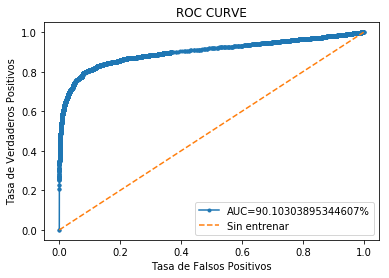

In [43]:
ns_probs = [0 for _ in range(len(y_test_p2))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test_p2, ns_probs)
fpr, tpr, _ = metrics.roc_curve(y_test_p2, y_pred_prob_p2)
plt.plot(fpr, tpr, marker='.', label="AUC="+str(auc_p2*100)+"%")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC CURVE')
plt.legend()
plt.show()


Comparando el resultado con lo solicitado, también logramos superar el **82%** solicitado. Por ende podemos predecir las conexiones futuras en la red con una mayor exactitud.


## **REFERENCIAS:**


- Torres, L. (2023). Curva ROC y AUC en python. The Machine Learners. https://www.themachinelearners.com/curva-roc-vs-prec-recall/
  -Fatima, U., Hina, S., & Wasif, M. (2022). A Novel Global Clustering Coefficient- Dependent Degree Centrality (Gccdc) Metric for Large Network Analysis Using Real-World Datasets. Social Science Research Network. https://doi.org/10.2139/ssrn.4284451
- Link Prediction — NetworkX 3.1 documentation. (2004). Retrieved May 10, 2023, from https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html
